# Beamforming

Beamforming consists of transmitting the same signal with slightly different offsets through multiple antennas.

This results in the focusing of a transmission beam through constructive interference.

To visualize that in action, we first need to build ns-3 from source, and download the 5G NR module from CTTC, which will perform the beamforming calculations.

We are also going to use tools to process videos, images and the Intel's ray-tracing Open Image Denoiser. More on that later.

```
sudo apt install g++ ninja-build cmake libsqlite3-dev libeigen3-dev gnuplot python3 python3-pip wget tar ffmpeg
pip install imageio imageio[ffmpeg] opencv-python numpy requests cppyy
git clone https://gitlab.com/nsnam/ns-3-dev
cd ns-3-dev/contrib
git clone https://gitlab.com/cttc-lena/nr
cd ../../
wget https://github.com/RenderKit/oidn/releases/download/v2.2.2/oidn-2.2.2.x86_64.linux.tar.gz
tar -xzf oidn-2.2.2.x86_64.linux.tar.gz
```

In [1]:
!pip install cppyy --no-use-pep517

Defaulting to user installation because normal site-packages is not writeable


First, let's import basic modules and check if you really installed Intel's OIDN

In [2]:
import subprocess
import ctypes
import sys
import os

currdir = os.path.abspath('')
# Check if Intel's OIDN was installed
oidn_dir = list(filter(lambda x: "oidn-2" in x and os.path.isdir(x), os.listdir("./")))
if not oidn_dir:
    raise Exception(
        "Download Intel Open Image Denoiser (https://github.com/OpenImageDenoise/oidn/releases/tag/v2.2.2) and extract it")
oidn_dir = oidn_dir[0]
denoiser = os.path.abspath(f"{currdir}/{oidn_dir}/bin/oidnDenoise")

Now let's add ns-3 with the 5G nr module to PATH, so that they can be imported successfuly.
Note that we won't import right now, because we are going to run them in separate processes (for parallel execution).

In [3]:
import sys
sys.path.append(f"{currdir}/ns-3-dev/build/bindings/python")
sys.path.append(f"{currdir}/ns-3-dev/build/lib")

Now we can define our ns-3 simulation code, which is adapted from nr's rem-beam-example.
Check the comments in the code for more details.

In [4]:
def runSimu(argpack):
    # Receives an argument pack containing:
    # - the number of the frame (used later to animate a series of frames)
    # - (x,y) coordinate of the UE in the space
    # - resolution of the REM map
    
    # If we have already run this simulation, skip it (fast resume in case we need to stop)
    frame, x, y, ha, va, resolution = argpack
    os.makedirs(f"{currdir}/frames/{frame}", exist_ok=True)
    os.chdir(f"{currdir}/frames/{frame}")
    if os.path.exists(f"{currdir}/frames/{frame}/nr-rem-0-sinr.png"):
        return

    # Import ns-3 and nr
    from ns import ns
    
    # gNB antenna parameters
    numRowsGnb = ctypes.c_uint32(va)
    numColumnsGnb = ctypes.c_uint32(ha)
    sector = ctypes.c_uint16(0)
    theta = ctypes.c_double(60)
    simTime = ctypes.c_double(1)

    # REM parameters (area to calculate and resolution)
    xMin = ctypes.c_double(-1000.0)
    xMax = ctypes.c_double(1000.0)
    xRes = ctypes.c_uint16(resolution)
    yMin = ctypes.c_double(-1000.0)
    yMax = ctypes.c_double(1000.0)
    yRes = ctypes.c_uint16(resolution)

    # Buffer to pass the simulation tag
    BUFFLEN = 4096
    outputFileBuffer = ctypes.create_string_buffer(b"0", BUFFLEN)
    simTag = ctypes.c_char_p(outputFileBuffer.raw)

    # Create gNB and UE
    gnbNodes = ns.NodeContainer()
    ueNodes = ns.NodeContainer()
    gnbNodes.Create(1)
    ueNodes.Create(1)

    # Install mobility and initialize positions
    mobility = ns.MobilityHelper()
    mobility.SetMobilityModel("ns3::ConstantPositionMobilityModel")
    mobility.Install(gnbNodes)
    gnbNodes.Get(0).__deref__().GetObject[ns.MobilityModel]().__deref__().SetPosition(ns.Vector(0, 0, 10))
    mobility.Install(ueNodes)
    ueNodes.Get(0).__deref__().GetObject[ns.MobilityModel]().__deref__().SetPosition(ns.Vector(x, y, 1.5))

    # Create and configure helpers
    ns.Config.SetDefault("ns3::ThreeGppChannelModel::UpdatePeriod", ns.TimeValue(ns.MilliSeconds(0)))
    epcHelper = ns.CreateObject[ns.NrPointToPointEpcHelper]()
    
    # Configure ideal beamforming with direct path
    idealBeamformingHelper = ns.CreateObject[ns.IdealBeamformingHelper]()
    nrHelper = ns.CreateObject[ns.NrHelper]()
    nrHelper.__deref__().SetBeamformingHelper(idealBeamformingHelper)
    nrHelper.__deref__().SetEpcHelper(epcHelper)
    idealBeamformingHelper.__deref__().SetAttribute("BeamformingMethod",
                                                    ns.TypeIdValue(ns.DirectPathBeamforming.GetTypeId()))
    # Create bandwidth part
    ccBwpCreator = ns.CcBwpCreator()
    numCcPerBand = ctypes.c_uint8(1)

    bandConf = ns.CcBwpCreator.SimpleOperationBandConf(2e9, 20e6, numCcPerBand)
    band = ccBwpCreator.CreateOperationBandContiguousCc(bandConf)

    # Initialize channel and pathloss, plus other things inside band.
    ns.Config.SetDefault("ns3::ThreeGppChannelModel::UpdatePeriod", ns.TimeValue(ns.MilliSeconds(0)))
    nrHelper.__deref__().SetPathlossAttribute("ShadowingEnabled", ns.BooleanValue(False))
    nrHelper.__deref__().InitializeOperationBand(band)
    singleBwp = ns.CcBwpCreator.GetAllBwps({band})

    # Antennas for the UEs
    nrHelper.__deref__().SetUeAntennaAttribute("NumRows", ns.UintegerValue(1))
    nrHelper.__deref__().SetUeAntennaAttribute("NumColumns", ns.UintegerValue(1))
    antennaElement = ns.CreateObject[ns.IsotropicAntennaModel]()
    nrHelper.__deref__().SetUeAntennaAttribute("AntennaElement", ns.PointerValue(antennaElement))

    # Configuration of phy and antenna for the gNbs
    nrHelper.__deref__().SetGnbPhyAttribute("TxPower", ns.DoubleValue(10))
    nrHelper.__deref__().SetGnbPhyAttribute("Numerology", ns.UintegerValue(0))
    nrHelper.__deref__().SetGnbAntennaAttribute("NumRows", ns.UintegerValue(numRowsGnb.value))
    nrHelper.__deref__().SetGnbAntennaAttribute("NumColumns", ns.UintegerValue(numColumnsGnb.value))
    antennaElement2 = ns.CreateObject[ns.ThreeGppAntennaModel]()
    nrHelper.__deref__().SetGnbAntennaAttribute("AntennaElement", ns.PointerValue(antennaElement2))

    # Install nr net devices
    gnbNetDev = nrHelper.__deref__().InstallGnbDevice(gnbNodes, singleBwp)
    ueNetDev = nrHelper.__deref__().InstallUeDevice(ueNodes, singleBwp)

    nrHelper.__deref__().AssignStreams(gnbNetDev, 1)
    nrHelper.__deref__().AssignStreams(ueNetDev, 2)

    # This is probably not necessary, since we did not update configuration after installation
    ns.DynamicCast[ns.NrGnbNetDevice](gnbNetDev.Get(0)).__deref__().UpdateConfig()
    ns.DynamicCast[ns.NrUeNetDevice](ueNetDev.Get(0)).__deref__().UpdateConfig()

    # Install the IP stack on the UEs, this is needed to allow attachment
    internet = ns.InternetStackHelper()
    internet.Install(ueNodes)
    epcHelper.__deref__().AssignUeIpv4Address(ns.NetDeviceContainer(ueNetDev))

    # We need to attach UEs to gNB so that they obtain the same configuration of channel as gNB
    nrHelper.__deref__().AttachToEnb(ueNetDev.Get(0), gnbNetDev.Get(0))

    # Configure REM parameters
    remHelper = ns.CreateObject[ns.NrRadioEnvironmentMapHelper]()
    remHelper.__deref__().SetMinX(xMin)
    remHelper.__deref__().SetMaxX(xMax)
    remHelper.__deref__().SetResX(xRes)
    remHelper.__deref__().SetMinY(yMin)
    remHelper.__deref__().SetMaxY(yMax)
    remHelper.__deref__().SetResY(yRes)
    remHelper.__deref__().SetSimTag(simTag)
    remHelper.__deref__().SetRemMode(ns.NrRadioEnvironmentMapHelper.BEAM_SHAPE)

    # Configure beam that will be shown in REM map
    ns.DynamicCast[ns.NrGnbNetDevice](gnbNetDev.Get(0)).GetPhy(
        0).GetSpectrumPhy().GetBeamManager().ChangeBeamformingVector(ueNetDev.Get(0));
    remHelper.__deref__().CreateRem(gnbNetDev, ueNetDev.Get(0), 0)

    ns.Simulator.Stop(ns.Seconds(simTime.value))
    ns.Simulator.Run()
    ns.Simulator.Destroy()

    # Generate gnuplot for REM map
    subprocess.check_output(
        (f"gnuplot -p nr-rem-0-gnbs.txt nr-rem-0-ues.txt nr-rem-0-buildings.txt nr-rem-0-plot-rem.gnuplot").split())

Pretty big code, no? We are working on reducing that. But anyways, what it does is to setup a gNB ("cell tower") and an UE nearby at a fixed location, then configure the offsets of the signals for each antenna, to calculate the resulting gain for each coordinate in the REM map. Let's see it in action.

In [6]:
def generate_frames(positions=None, horizontal_antennas=4, vertical_antennas=4, rem_resolution=100):
    import itertools
    # Create list of UE positions
    if not positions:
        params = list(zip(itertools.repeat(500), range(-500, 500, 500)))
    else:
        params = positions
    
    # Transform list of positions into tuple containing: 
    # - number of frame
    # - x,y position of ue
    # - horizontal and vertical antennas
    # - REM resolution
    params = [(i, *params[i], horizontal_antennas, vertical_antennas, rem_resolution) for i in range(len(params))]
    
    # Dispatch simulations to generate each frame from the visualization in parallel
    from concurrent.futures import ProcessPoolExecutor
    import shutil
    import os
    
    shutil.rmtree("frames", ignore_errors=True)
    os.makedirs("frames", exist_ok=True)
    with ProcessPoolExecutor(max_workers=min(os.cpu_count()-1, 8)) as pool:
        list(pool.map(runSimu, params))
    
    return list(sorted(map(lambda x: int(x), os.listdir("frames"))))

In [7]:
frames = generate_frames(positions=None, horizontal_antennas=4, vertical_antennas=4, rem_resolution=100)

[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { $.cling-module-136.__inits.0, __cxx_global_var_initcling_module_136_, _GLOBAL__sub_I_cling_module_136, __orc_init_func.cling-module-136, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { $.cling-module-136.__inits.0, _GLOBAL__sub_I_cling_module_136, __orc_init_func.cling-module-136, __cxx_global_var_initcling_module_136_, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }


gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)


Now let us see these figures. First some glue code to plot them.

In [8]:
def plot_figure(file, axis=None):
    from PIL import Image
    import io
    if not os.path.exists(file):
        raise Exception(f"Inexisting file: {file}")
        
    with open(file, "rb") as f:
        contents = f.read()
    image = Image.open(io.BytesIO(contents))

    if not axis:
        import matplotlib.pyplot as plt
        plt.imshow(image)
    else:
        axis.imshow(image)
        
def plot_frames(frames):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(nrows=1, ncols=len(frames), squeeze=False)
    for frame in frames:
        ax[0][frame].set_yticks([])
        ax[0][frame].set_xticks([])
        plot_figure(f"./frames/{frame}/nr-rem-0-sinr.png", ax[0][frame])

Now the actual REM map.

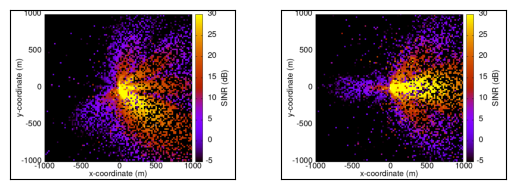

In [9]:
plot_frames(frames)

Very nice! We can already see that the radiation pattern changed as the UE moved upward (from Y=-500 to Y=0), but it is hard to know exactly what happened due to such low resolution.
Let's try again with higher resolution.

[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { _ZN3ns3L16g_timeInitHelperE, $.cling-module-136.__inits.0, __cxx_global_var_initcling_module_136_, __orc_init_func.cling-module-136, _GLOBAL__sub_I_cling_module_136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { $.cling-module-136.__inits.0, _GLOBAL__sub_I_cling_module_136, __orc_init_func.cling-module-136, _ZN3ns3L16g_timeInitHelperE, __cxx_global_var_initcling_module_136_ }) }
[runStaticInitializersOnce]: [runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }
Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }


gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)


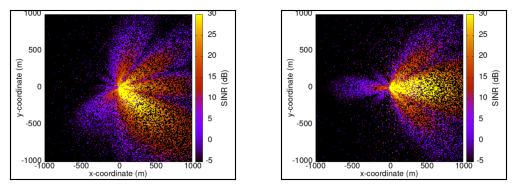

In [10]:
frames = generate_frames(positions=None, horizontal_antennas=4, vertical_antennas=4, rem_resolution=200)
plot_frames(frames)

Much clearer figure, but we can still get a better one with higher res. It takes a lot longer? Yes. But have some patience.

[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __cxx_global_var_initcling_module_136_, $.cling-module-136.__inits.0, _GLOBAL__sub_I_cling_module_136, _ZN3ns3L16g_timeInitHelperE, __orc_init_func.cling-module-136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136, _GLOBAL__sub_I_cling_module_136, __cxx_global_var_initcling_module_136_, $.cling-module-136.__inits.0, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }


gnb is RTD (transmitter)
gnb is RTD (transmitter)
ue is RRD (receiver)
ue is RRD (receiver)


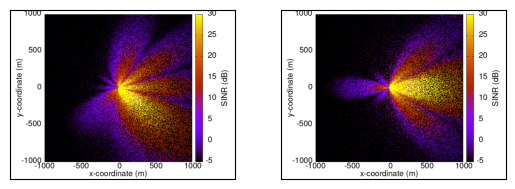

In [11]:
frames = generate_frames(positions=None, horizontal_antennas=4, vertical_antennas=4, rem_resolution=1000)
plot_frames(frames)

Much better figure. We can now clearly see that the antenna model is directional, and to the right side of the figure.
You should be now be able to clearly see a main lobe, with is targeting that is being directed to the UE.
You should also see secondary lobes, with muck lower SINR at the sides of the main lobe.
There is also some other lower power lobes coming out of the back of the antenna array.

We can now look at the effect of increasing the number of antenna elements in an array, and how it impacts beamforming.

A lower number of elements should give us a wider lower-power beam, while more elements should give us a focused higher-power beam.

Let's observe a 2x2 array vs a 8x8 array.

[runStaticInitializersOnce]: [runStaticInitializersOnce]: Failed to materialize symbols: { (main, { _GLOBAL__sub_I_cling_module_136, $.cling-module-136.__inits.0, __orc_init_func.cling-module-136, __cxx_global_var_initcling_module_136_, _ZN3ns3L16g_timeInitHelperE }) }
Failed to materialize symbols: { (main, { __cxx_global_var_initcling_module_136_, __orc_init_func.cling-module-136, _GLOBAL__sub_I_cling_module_136, $.cling-module-136.__inits.0, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }


gnb is RTD (transmitter)
gnb is RTD (transmitter)
ue is RRD (receiver)
ue is RRD (receiver)


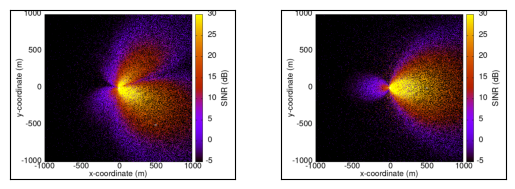

In [12]:
frames = generate_frames(positions=None, horizontal_antennas=2, vertical_antennas=2, rem_resolution=1000)
plot_frames(frames)

[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { _GLOBAL__sub_I_cling_module_136, _ZN3ns3L16g_timeInitHelperE, $.cling-module-136.__inits.0, __orc_init_func.cling-module-136, __cxx_global_var_initcling_module_136_ }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { $.cling-module-136.__inits.0, __cxx_global_var_initcling_module_136_, _GLOBAL__sub_I_cling_module_136, __orc_init_func.cling-module-136, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136 }) }


gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)


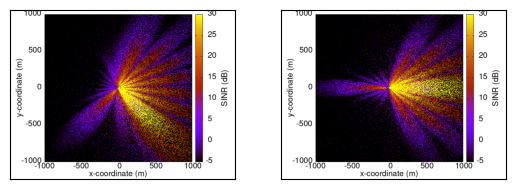

In [13]:
frames = generate_frames(positions=None, horizontal_antennas=8, vertical_antennas=8, rem_resolution=1000)
plot_frames(frames)

We can confirm increasing the number of elements gives is a more focused beam.

It would be interesting to see how the beam behaves while the UE is moving.

This can be very easily achieved using the same tools we have been using.

We just need to generate more positions, apply some denoiser and then animate them.

First, let's see what a denoiser does.

In [ ]:
def denoise_frames(frames):
    # Import numpy and opencv to convert output pngs generated by gnuplot into pfm images accepted by OIDN
    import cv2
    import numpy as np
    import imageio

    # Write to PFM file (OpenCV does not have a direct function to save PFM, so we'll define it)
    def write_pfm(filename, image, scale=1):
        with open(filename, "wb") as file:
            color = None
            if image.dtype.name != 'float32':
                raise Exception('Image dtype must be float32.')
    
            image = cv2.flip(image, 0)
            if len(image.shape) == 3 and image.shape[2] == 3:  # color image
                color = True
            elif (len(image.shape) == 2) or (len(image.shape) == 3 and image.shape[2] == 1):  # grayscale
                color = False
            else:
                raise Exception('Image must have H x W x 3, H x W x 1 or H x W dimensions.')
    
            file.write('PF\n'.encode() if color else 'Pf\n'.encode())
            file.write(f'{image.shape[1]} {image.shape[0]}\n'.encode())
    
            endian = image.dtype.byteorder
    
            if endian == '<' or endian == '=' and sys.byteorder == 'little':
                scale = -scale
    
            file.write(f'{scale}\n'.encode())
    
            image.tofile(file)
    
    
    # Read the denoised PFM
    def read_pfm(file):
        import re
        with open(file, "rb") as f:
            # read header
            type = f.readline().decode('latin-1').rstrip()
            if type == 'PF':
                color = True
            elif type == 'Pf':
                color = False
            else:
                raise Exception('Not a PFM file.')
    
            dim_match = re.match(r'^(\d+)\s(\d+)\s$', f.readline().decode('latin-1'))
            if dim_match:
                width, height = map(int, dim_match.groups())
            else:
                raise Exception('Malformed PFM header.')
    
            scale = float(f.readline().rstrip())
            if scale < 0:  # little-endian
                endian = '<'
                scale = -scale
            else:
                endian = '>'  # big-endian
    
            data = np.fromfile(f, endian + 'f')
            shape = (height, width, 3) if color else (height, width)
            data = np.reshape(data, shape)
            data = cv2.flip(data, 0)
            return data, scale
    
    files = []
    for frame in frames:
        # Move to the directory of the currently processed frame
        os.chdir(f"{currdir}/frames/{frame}")
        # Load the PNG image, convert to floating point and write pfm
        image = cv2.imread('nr-rem-0-sinr.png', cv2.IMREAD_UNCHANGED)
        normalized_image = image.astype(np.float32) / 255.0
        write_pfm('input.pfm', normalized_image)
    
        # Perform denoising using Intel's Open Image Denoise
        subprocess.check_output((f"{denoiser} -ldr input.pfm -o output.pfm").split())
    
        # Read PFM and convert back to PNG
        denoised_image, _ = read_pfm('output.pfm')
        cv2.imwrite('denoised-nr-rem-0-sinr.png', (denoised_image * 255).astype(np.uint8))
    
        # Go back to this script directory
        os.chdir(currdir)
    
        # Append png to the list of images in the resulting video/gif
        files.append(imageio.imread(f"frames/{frame}/denoised-nr-rem-0-sinr.png"))
    return files
    
def plot_denoised_frames(frames):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(nrows=1, ncols=len(frames), squeeze=False)
    frames_data = denoise_frames(frames)
    print(len(frames_data))
    for frame, frame_data in zip(frames, frames_data):
        ax[0][frame].set_yticks([])
        ax[0][frame].set_xticks([])
        ax[0][frame].imshow(frame_data)

/tmp/ipykernel_1570/1423141836.py:87: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  files.append(imageio.imread(f"frames/{frame}/denoised-nr-rem-0-sinr.png"))


2


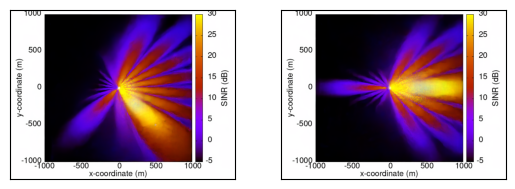

In [15]:
plot_denoised_frames(frames)

In [26]:
# Set the number of simulations and positioning of UE
import itertools
params = list(zip(itertools.repeat(500), range(-500, 500, 100)))
params += list(zip(range(500, -500, -100), itertools.repeat(500)))
params += list(zip(itertools.repeat(-500), range(500, -500, -100)))
params += list(zip(range(-500, 500, 100), itertools.repeat(-500)))

frames = generate_frames(positions=params, horizontal_antennas=4, vertical_antennas=4, rem_resolution=500)

[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-136, _GLOBAL__sub_I_cling_module_136, $.cling-module-136.__inits.0, __cxx_global_var_initcling_module_136_, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __cxx_global_var_initcling_module_136_, _GLOBAL__sub_I_cling_module_136, __orc_init_func.cling-module-136, $.cling-module-136.__inits.0, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { _ZN3ns3L16g_timeInitHelperE, _GLOBAL__sub_I_cling_module_136, __cxx_global_var_initcling_module_136_, $.cling-module-136.__inits.0, __orc_init_func.cling-module-136 }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { _GLOBAL__sub_I_cling_module_136, __orc_init_func.cling-module-136, __cxx_global_var_initcling_module_136_, $.cling-module-136.__inits.0, _ZN3ns3L16g_timeInitHelperE }) }
[runStaticInitializersOnce]: Failed 

gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)
gnb is RTD (transmitter)
ue is RRD (receiver)

 REM done:1 %. Minutes up to now: 0.0256146. Minutes left estimated:2.53585.
 REM done:10 %. Minutes up to now: 0.233496. Minutes left estimated:2.10147.
 REM done:20 %. Minutes up to now: 0.478253. Minutes left estimated:1.91302.
 REM done:30 %. Minutes up to now: 0.718351. Minutes left estimated:1.67616.
 REM done:40 %. Minutes up to now: 0.957151. Minutes left estimated:1.43574.
 REM done:50 %. Minutes up to now: 1.22733. Minutes left estimated:1.22734.
 REM done:60 %. Minutes up to now: 1.50457. Minutes left estimated:1.00305.
 REM done:70 %. Minutes up to now: 1.79718. Minutes left estimated:0.77023.
 REM done:80 %. Mi

In [28]:
# Save output file (.gif for image, .mp4 for video)
import imageio
imageio.mimsave('./animated_rem.mp4', denoise_frames(frames))

/tmp/ipykernel_1570/1423141836.py:87: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  files.append(imageio.imread(f"frames/{frame}/denoised-nr-rem-0-sinr.png"))


In [31]:
from IPython.display import Video
Video("animated_rem.mp4")

We can see the beam tracking the user as it moves around the cell. Note that when it moves behind the cell, the cell can't reach it with its main lobe, but can reach it with a lower power lobe. That is not a scenario you should expect in real life, since the base stations will have cells pointing to different sectors, and will switch the user from a sector to another (typically via intra-gNB handover).

If you are not happy with the smoothness of the animation (like me!!!) you can increase the number of frames generated by reducing the distance between them (from 100 meters to something else). But this will take a long time.

An alternative is using an AI frame interpolator to create fake frames between the real ones. It works just fine, see Nvidia DLSS Frame Generation/AMD Fluid Motion Frames/any random TV where the content seems unnaturally smooth.

Here, we are going to use [ECCV2022-RIFE](https://github.com/hzwer/ECCV2022-RIFE?tab=readme-ov-file).

After cloning it, and downloading the trained model, run in the command line:
```
cd ECCV2022-RIFE
python3 inference_video.py --exp=4 --video=../animated_rem.mp4
cd ..
ffmpeg -i animated_rem_16X_160fps.mp4 animated_rem_smooth.mp4
```

In [30]:
from IPython.display import Video
Video("animated_rem_smooth.mp4", embed=True)